<h1>Predicting House Sale Prices</h1>

In the DataQuest course I have been gaining intuition for model based learning, and explored how the linear regression model works. Whilst studying the basics of linear regression, and the two approaches to model fitting (Gradient Descent, and Ordinary Least Squares), I have also picked up techniques for cleaning, transfomring and selecting features. The selection of appropriate features, and the transformation of features prior to creating a model is one of, if not the most, important steps.

In this project I am going to practice what I have learnt by trying to create a model for predicting house prices using the ASA dataset. In this notebook I will demonstrate how to transform features to make them suitable for modelling, and how to select features for the best performance.

I will start by exploring the dataset, and then setting up a pipeline of functions so I can quickly iterate on different models. I am going to demonstrate three seperate validation methods: holdout, k-fold cross-validation, and leave-one-out cross-validation.

In [170]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

In [171]:
#Import the data into a pandas dataframe
data = pd.read_csv('AmesHousing.txt', delimiter='\t')

<h2>Data Exploration</h2>

The first step is to get some intuition as to what data I actually have here. I know from the start that my target column (i.e. my labels) is "SalePrice" but I want to chose the best features for my model, drop features that do not hold any valuable information, deal with missing data, and transform or even create new features where appropriate. To do all this I need to understand the dataset I am dealing with.

In [172]:
data.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


In [173]:
data.shape

(2930, 82)

So first I will split the data evenly into test and train datasets, and then later on I will be performing k-fold cross-validation.

In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [175]:
data.get_dtype_counts()

float64    11
int64      28
object     43
dtype: int64

Using the information from the pandas dataframe above, combined with the <a href="https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt">data documentation</a> it is clear that there is alot of categorical data. I will come back to these categorical columns later on.

For now, I am going to assess the following:
* How much missing data is there?
* Are there any columns that do not provide any meaningful information?
* What columns potentially leak information about the sale and should therefore be removed

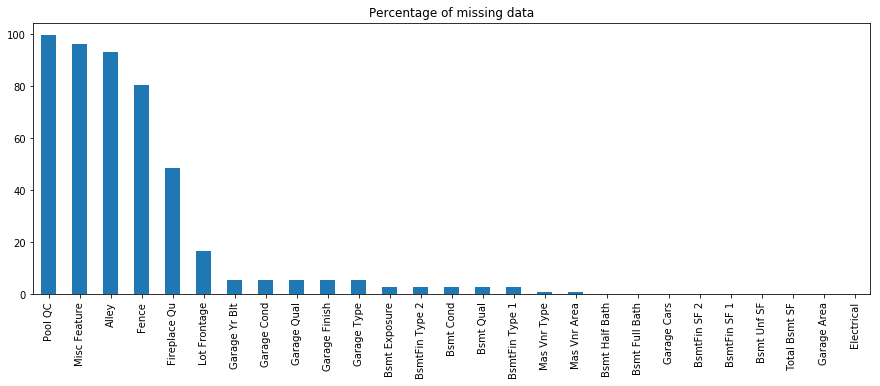

In [176]:
#Get columns with missing data
def show_missing_data():
    missing_data_columns = data.columns[data.isnull().any()]
    missing_data = data[missing_data_columns]
    percentage_missing_data = np.abs((missing_data.isnull().sum())/missing_data.shape[0] * 100)
    percentage_missing_data = percentage_missing_data.sort_values(ascending=False)
    percentage_missing_data.plot(kind='bar', figsize=(15,5), title="Percentage of missing data")
    plt.show()
show_missing_data()

The 'Misc Feature' column is for 'Miscellaneous feature not covered in other categories'. The majority of properties do not have any information for this columns, so I will just drop it.

As for the column 'Pool QC', the documentation states that a value of NA corresponds to 'No Pool'. This columns is categorical, and so if I replace the null values with the value 'No Pool' I can use this column later on. This will preserve information which might be useful for predicting sale prices. The same goes for 'Fireplace Qu', where a value of NA will instead be replaced with "No Fireplace".

A null value for the columns 'Alley' and the column 'Fence', which are both also categorical, represent no alley way access or no fence, respectively. I will therefore treat these columns in the same way as I have 'Pool QC' and 'Fireplace Qu'.

'Lot Frontage', which contains just under 20% missing data, is a bit more complicated. This column contains numerical data about the linear feet of street connexted to the property. One technique we can employ is imputation - replacing missing values with a descriptive statistic. Taking the average across the entire dataset will likely be misleading. The dataset does however contain information pertaining to the location of the property in the 'Neighbourhood' column. So what I will do instead is take the average 'Lot Frontage' for properties in each area, and replace missing values with this average in accordance to their 'Neighbourhood'.


In [177]:
#Drop the Misc Feature column
data = data.drop(['Misc Feature'], axis=1)

In [178]:
#Fill categorical data with None values
data['Pool QC'].fillna('No Pool', inplace=True)
data['Fireplace Qu'].fillna('No Fireplace', inplace=True)
data['Alley'].fillna('No Alley Access', inplace=True)
data['Fence'].fillna('No Fence', inplace=True)

In [179]:
#Replace null values with the average for the neighbourhood
data['Lot Frontage'] = data.groupby('Neighborhood')['Lot Frontage'].transform(lambda x: x.fillna(np.mean(x)))

In [180]:
data['Lot Frontage'].isnull().sum()

3

In [181]:
data[data['Lot Frontage'].isnull()]

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2256,2257,916253320,120,RM,NaN,9763,Pave,No Alley Access,IR1,Lvl,...,0,0,No Pool,No Fence,0,9,2007,WD,Normal,330000
2788,2789,907230240,160,RH,NaN,3612,Pave,No Alley Access,IR1,Lvl,...,0,0,No Pool,MnPrv,0,6,2006,WD,Normal,137000
2892,2893,916252170,120,RM,NaN,8239,Pave,No Alley Access,IR1,Lvl,...,0,0,No Pool,No Fence,0,11,2006,WD,Normal,230000


As you can see in the cell above, there appears to still be three records with a null value for Lot Frontage. After further inspecition this appears to have occured because there is no Lot Frontage data for the neighborhoods that these three properties reside in. As there are only three records which are problematic, I shall just drop them.

In [183]:
data = data[data['Lot Frontage'].notnull()]

In [184]:
data['Lot Frontage'].isnull().sum()

0

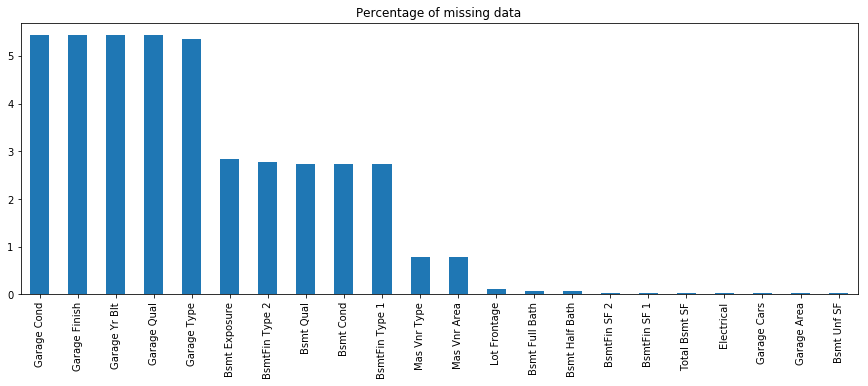

In [182]:
show_missing_data()

So now I have the question of what to do with the remaining missing data:
* Garage data: the missing values in the columns related to the garage is related to properties that have no garage. So for categorical data relating to the garage, I will replace the null values with "no garage", and the numerical values I will simply attribute a value of zero.
* Basement data: columns that begin with the prefix 'Bmst' relate to the basement. Like with the garage data, the missing values are attributed to properties with no basement.
* All other missing values after processing the above will be emitted from my dataset

In [188]:
#Amend garage data
data['Garage Cond'].fillna('No Garage', inplace=True)
data['Garage Finish'].fillna('No Garage', inplace=True)
data['Garage Yr Blt'].fillna(0, inplace=True)
data['Garage Qual'].fillna('No Garage', inplace=True)
data['Garage Type'].fillna('No Garage', inplace=True)
#Amend basement data
data['Bsmt Exposure'].fillna('No Basement', inplace=True)
data['BsmtFin Type 2'].fillna('No Basement', inplace=True)
data['Bsmt Qual'].fillna('No Basement', inplace=True)
data['Bsmt Cond'].fillna('No Basement', inplace=True)
data['BsmtFin Type 1'].fillna('No Basement', inplace=True)

In [189]:
data.dropna(inplace=True)

In [190]:
data.shape

(2900, 81)

In [192]:
data.isnull().sum().sum()

0

In [153]:
def transform_features(df,missing_data_threshold):
    
    return df

In [154]:
def select_features():
    feature_columns = ['Gr Liv Area']
    return feature_columns

In [155]:
def train_and_test(df,cv_type='kfold',n_folds=5):
    if cv_type = 'None':
        #DO HOLDOUT
    elif cv_type = 'kfold':
        #DO KFOLD
    elif cv_type = 'LOOCV':
        #DO Leave One Out Cross Val
    return None

SyntaxError: invalid syntax (<ipython-input-155-3a6b5f9e869a>, line 2)

In [ ]:
test_and_train(5)